In [1]:
import numpy as np, pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import subplots
from sklearn.linear_model import \
     (LinearRegression,
      LogisticRegression,
      Lasso)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import \
     (train_test_split,
      GridSearchCV)
import torch
from torch import nn
import torch.optim as optim
from torch.optim import RMSprop
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

In [2]:
RANDOM_SEED = 42
data = pd.read_csv('processed_credit_score_data.csv')
data.T

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
month,1,2,3,4,5,6,7,8,1,2,...,7,8,1,2,3,4,5,6,7,8
age,23,23,23,23,23,23,23,23,28,28,...,28,29,24,25,25,25,25,25,25,25
annual_income,19114.12,19114.12,19114.12,19114.12,19114.12,19114.12,19114.12,19114.12,34847.84,34847.84,...,20002.88,20002.88,39628.99,39628.99,39628.99,39628.99,39628.99,39628.99,39628.99,39628.99
total_emi_per_month,49.574947,49.574947,49.574947,49.574947,49.574947,49.574947,49.574947,49.574947,18.816216,18.816216,...,60.96477,60.96477,35.104023,35.104023,35.104023,35.104023,35.104023,35.104023,35.104023,35.104023
num_bank_accounts,3,3,3,3,3,3,3,3,2,2,...,10,10,4,4,4,4,4,4,4,4
num_credit_card,4,4,4,4,4,4,4,4,4,4,...,8,8,6,6,6,6,6,6,6,6
interest_rate,3,3,3,3,3,3,3,3,6,6,...,29,29,7,7,7,7,7,7,7,7
num_of_loan,4,4,4,4,4,4,4,4,1,1,...,5,5,2,2,2,2,2,2,2,2
delay_from_due_date,3,-1,3,5,6,8,3,3,3,7,...,33,33,23,23,20,23,18,27,20,18
num_of_delayed_payment,7,7,7,4,4,4,8,6,4,1,...,26,25,6,6,6,7,7,6,6,6


In [3]:
data['credit_mix'] = data['credit_mix'].map({'Good': 2, 'Standard': 1, 'Bad': 0})

data['credit_mix'] = pd.to_numeric(data['credit_mix'], downcast='integer')

In [4]:
data = data.drop(columns=['month','credit_score'])
#data = pd.get_dummies(data, drop_first=True)
print(data.columns)
print(data.shape)

Index(['age', 'annual_income', 'total_emi_per_month', 'num_bank_accounts',
       'num_credit_card', 'interest_rate', 'num_of_loan',
       'delay_from_due_date', 'num_of_delayed_payment', 'changed_credit_limit',
       'num_credit_inquiries', 'credit_mix', 'outstanding_debt',
       'credit_utilization_ratio', 'credit_history_age',
       'payment_of_min_amount', 'amount_invested_monthly', 'monthly_balance',
       'spent', 'payment', 'Accountant', 'Architect', 'Developer', 'Doctor',
       'Engineer', 'Entrepreneur', 'Journalist', 'Lawyer', 'Manager',
       'Mechanic', 'Media_Manager', 'Musician', 'Scientist', 'Teacher',
       'Writer'],
      dtype='object')
(100000, 35)


In [5]:
# Define the feature variables X and the target variable Y
Y = data['payment_of_min_amount']  # Target variable
X = data.drop(columns=['payment_of_min_amount'])  # Feature variables (drop the target variable)

In [6]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, 
                                                    stratify=Y, random_state=RANDOM_SEED)

# Define the columns that need to be scaled with RobustScaler
robust_columns = ['total_emi_per_month', 'amount_invested_monthly', 'monthly_balance']

# Define the columns that need to be scaled with StandardScaler (all non-robust columns)
standard_columns = [col for col in X_train.columns if col not in robust_columns]

# Create a ColumnTransformer to apply different scalers to specified columns
scaler = ColumnTransformer(
    transformers=[
        ('standard', StandardScaler(), standard_columns),
        ('robust', RobustScaler(), robust_columns)
    ]
)

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same transformation to the test data (without fitting again)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Convert the target variables to LongTensors
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.long)  # Convert to one-dimensional tensor
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.long)    # Convert to one-dimensional tensor

# Display the results
print("X_train_tensor:", X_train_tensor)
print("Y_train_tensor:", Y_train_tensor)

X_train_tensor: tensor([[-1.5171, -0.7913,  0.6306,  ...,  0.0352, -0.2758, -0.3989],
        [-0.3085,  0.4542,  1.4027,  ...,  2.0061,  0.3874, -0.0914],
        [-1.1452, -0.8016,  0.2445,  ...,  0.0148, -0.3065, -0.3781],
        ...,
        [ 1.4578,  0.4003, -2.0718,  ..., -0.5646, -0.0804,  1.6152],
        [ 1.6437,  2.0296,  0.2445,  ...,  0.5379,  0.0838,  3.4818],
        [ 0.1563, -0.5666,  0.6306,  ..., -0.3879, -0.1201,  0.2281]])
Y_train_tensor: tensor([1, 1, 1,  ..., 0, 0, 1])


In [7]:
# Load
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
class MinPayModel(nn.Module):
    def __init__(self, input_features, output_features=1, hidden_units=256, dropout_rate=0.25):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(in_features=hidden_units, out_features=128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(in_features=64, out_features=output_features),
            nn.Sigmoid()  # Sigmoid function
        )

    def forward(self, x_credit):
        x = self.linear_layer_stack(x_credit)
        return x

# fit model
model = MinPayModel(input_features=34).to(device)

In [10]:
# Define the loss function with binary cross-entropy and logits
criterion = nn.BCEWithLogitsLoss()  # Suitable for binary classification with logits

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with a learning rate of 0.001

num_epochs = 750  # Total number of training epochs
patience = 70  # Number of epochs to wait for improvement in validation accuracy
best_val_accuracy = 0  # Variable to track the best validation accuracy
epochs_without_improvement = 0  # Counter for epochs without improvement in validation accuracy

Epoch [10/750], 
            Train Loss: 0.4950, 
            Val Loss: 0.4952, 
            Val Accuracy: 0.9022
Epoch [20/750], 
            Train Loss: 0.4929, 
            Val Loss: 0.4927, 
            Val Accuracy: 0.9157
Epoch [30/750], 
            Train Loss: 0.4904, 
            Val Loss: 0.4915, 
            Val Accuracy: 0.9270
Epoch [40/750], 
            Train Loss: 0.4889, 
            Val Loss: 0.4899, 
            Val Accuracy: 0.9265
Epoch [50/750], 
            Train Loss: 0.4876, 
            Val Loss: 0.4884, 
            Val Accuracy: 0.9275
Epoch [60/750], 
            Train Loss: 0.4868, 
            Val Loss: 0.4868, 
            Val Accuracy: 0.9357
Epoch [70/750], 
            Train Loss: 0.4845, 
            Val Loss: 0.4851, 
            Val Accuracy: 0.9347
Epoch [80/750], 
            Train Loss: 0.4833, 
            Val Loss: 0.4853, 
            Val Accuracy: 0.9288
Epoch [90/750], 
            Train Loss: 0.4821, 
            Val Loss: 0.4825, 
       

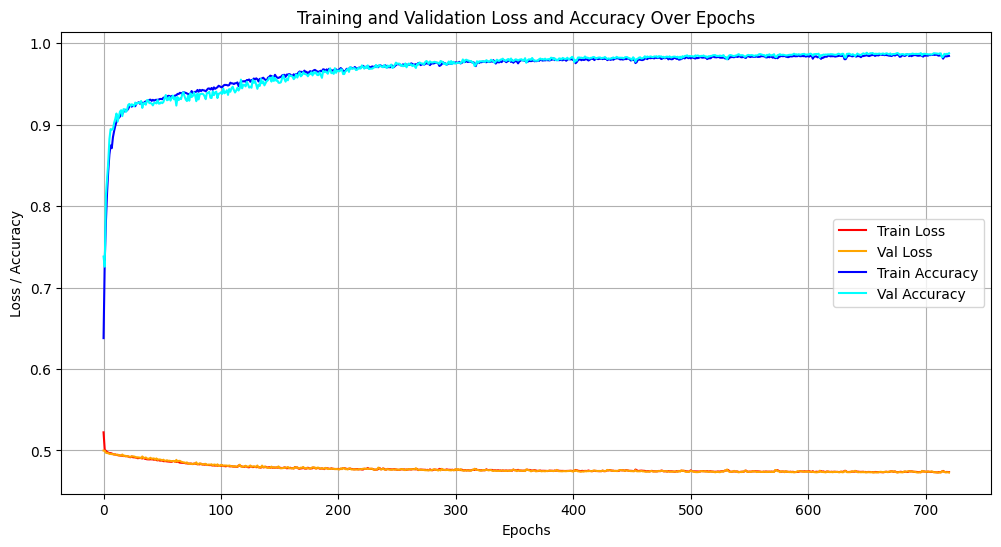

In [11]:
# Lists to record loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop for the specified number of epochs
for epoch in range(num_epochs):
    model.train()  # Switch to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Iterate over batches in the training data
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
        optimizer.zero_grad()  # Clear gradients from the previous step
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs.squeeze(), labels.float())  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        running_loss += loss.item()  # Accumulate loss
        
        # Calculate training accuracy
        predicted = torch.round(torch.sigmoid(outputs))  # Convert outputs to 0 or 1
        total += labels.size(0)  # Update total count
        correct += (predicted.squeeze() == labels).sum().item()  # Count correct predictions

    # Calculate average training loss and accuracy
    average_loss = running_loss / len(train_loader)
    train_losses.append(average_loss)  # Record training loss
    train_accuracies.append(correct / total)  # Record training accuracy

    # Evaluation on validation set
    model.eval()  # Switch to evaluation mode
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():  # Disable gradient calculation for validation
        val_outputs = model(X_test_tensor.to(device))  # Ensure test data is also on the GPU
        val_loss = criterion(val_outputs.squeeze(), Y_test_tensor.to(device).float())  # Calculate validation loss
        val_running_loss = val_loss.item()  # Get validation loss
        
        val_predictions = torch.round(torch.sigmoid(val_outputs))  # Convert outputs to 0 or 1
        val_accuracy = (val_predictions.squeeze() == Y_test_tensor.to(device)).float().mean().item()  # Compute validation accuracy
        val_accuracies.append(val_accuracy)  # Record validation accuracy

    val_losses.append(val_running_loss)  # Record validation loss

    # Print information every ten epochs
    if (epoch + 1) % 10 == 0:
        print(f'''Epoch [{epoch + 1}/{num_epochs}], 
            Train Loss: {average_loss:.4f}, 
            Val Loss: {val_running_loss:.4f}, 
            Val Accuracy: {val_accuracy:.4f}''')
    
    # Early stopping mechanism
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy  # Update best validation accuracy
        epochs_without_improvement = 0  # Reset counter if validation accuracy improves
    else:
        epochs_without_improvement += 1  # Increment counter if no improvement
        if epochs_without_improvement >= patience:  # Check for early stopping condition
            print("Early stopping triggered.")
            break

# Create a DataFrame to plot loss and accuracy curves
metrics_df = pd.DataFrame({
    'Train Loss': train_losses,
    'Val Loss': val_losses,
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies
})

# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 6))

# Plot training loss and validation loss
plt.plot(metrics_df['Train Loss'], color='red', label='Train Loss')
plt.plot(metrics_df['Val Loss'], color='orange', label='Val Loss')

# Plot training accuracy and validation accuracy
plt.plot(metrics_df['Train Accuracy'], color='blue', label='Train Accuracy')
plt.plot(metrics_df['Val Accuracy'], color='cyan', label='Val Accuracy')

# Set legend, title, and labels
plt.title('Training and Validation Loss and Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.grid()  # Add a grid for better readability
plt.show()  # Display the plot

Accuracy: 98.77%
              precision    recall  f1-score   support

     Class 0       0.99      0.98      0.98      8114
     Class 1       0.99      0.99      0.99     11886

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



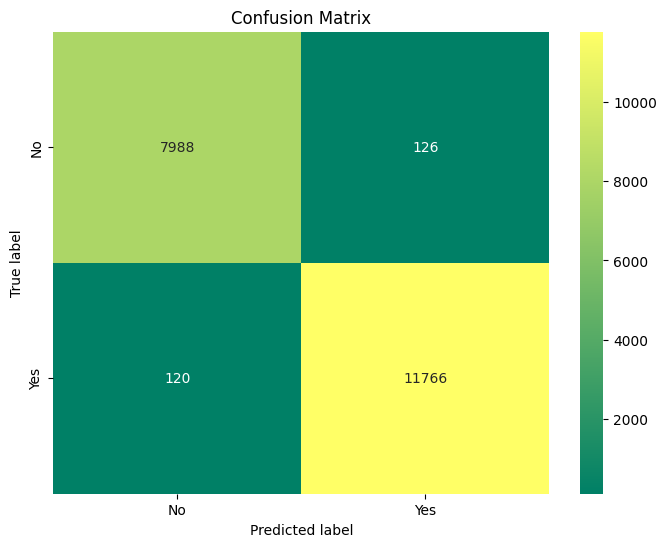

In [12]:
# Model evaluation
model.eval()  # Switch to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    correct = 0
    total = 0
    all_labels = []  # Store all true labels
    all_predictions = []  # Store all predicted labels
    
    # Use DataLoader for batch evaluation
    for inputs, labels in DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=512):
        inputs, labels = inputs.to(device), labels.to(device)  # Ensure inputs are on the same device
        outputs = model(inputs)  # Forward pass

        # For binary classification, use the Sigmoid function to convert logits to probabilities
        probabilities = torch.sigmoid(outputs).squeeze()  # Convert (N, 1) to (N,)
        predicted = (probabilities > 0.5).long()  # Use 0.5 as the threshold for classification

        total += labels.size(0)  # Update total count
        correct += (predicted == labels).sum().item()  # Count correct predictions

        # Collect all true labels and predictions
        all_labels.extend(labels.cpu().numpy())  # Convert to numpy and store
        all_predictions.extend(predicted.cpu().numpy())  # Convert to numpy and store

    # Print accuracy
    print(f'Accuracy: {100 * correct / total:.2f}%')

    # Generate classification report
    print(classification_report(all_labels, all_predictions, target_names=['Class 0', 'Class 1']))

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='summer', 
                xticklabels=['No', 'Yes'],  # Define x-axis labels
                yticklabels=['No', 'Yes'])  # Define y-axis labels
    plt.ylabel('True label')  # Label for the y-axis
    plt.xlabel('Predicted label')  # Label for the x-axis
    plt.title('Confusion Matrix')  # Title for the plot
    plt.show()  # Display the plot